In [50]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from IPython.display import display

query = '국내 여행'
url = f'https://search.naver.com/search.naver?where=view&sm=tab_jum&query={query}'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
results = soup.select('a.title_link')

data = []
for result in results:
    title = result.text
    link = result['href']
    data.append([title, link])

df = pd.DataFrame(data, columns=['Title', 'Link'])
df.to_csv('holiday_recommendations.csv', index=False, encoding='utf-8-sig')
df = pd.read_csv('holiday_recommendations.csv')
display(df)

,Title,Link


In [15]:
# 필요한 라이브러리 import
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns

In [16]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

In [17]:
# 데이터 불러오기
df = pd.read_csv("./data/DATA_2022년_국민여행조사_원자료.csv", encoding='cp949', low_memory=False)

# 필요한 칼럼 추가로 추출
df = df[['D_TRA1_CASE', 'D_TRA1_COST', 'D_TRA1_ONE_COST', 'A9C', 'A9D']]

In [18]:
# 결측치 제거
df = df.dropna()

# 'A9C'와 'A9D' 칼럼이 문자열이라면 숫자로 변환
if df['A9C'].dtype == 'object':
    df['A9C'] = encoder.fit_transform(df['A9C'])
if df['A9D'].dtype == 'object':
    df['A9D'] = encoder.fit_transform(df['A9D'])

In [19]:
# 여행 비용 칼럼과 1인당 여행비용 칼럼을 10만원 단위로 반올림
df['D_TRA1_COST'] = np.round(df['D_TRA1_COST'].astype(float) / 100000) * 100000
df['D_TRA1_ONE_COST'] = np.round(df['D_TRA1_ONE_COST'].astype(float) / 100000) * 100000

# 필요한 칼럼만으로 새로운 데이터프레임 생성
df_new = df[['D_TRA1_ONE_COST', 'D_TRA1_COST', 'A9C', 'A9D']]

In [20]:

# 데이터 정규화
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_new), columns=df_new.columns)

# k-means 클러스터링
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42).fit(df_scaled)

# 클러스터링 결과 추가
df['Cluster'] = kmeans.labels_

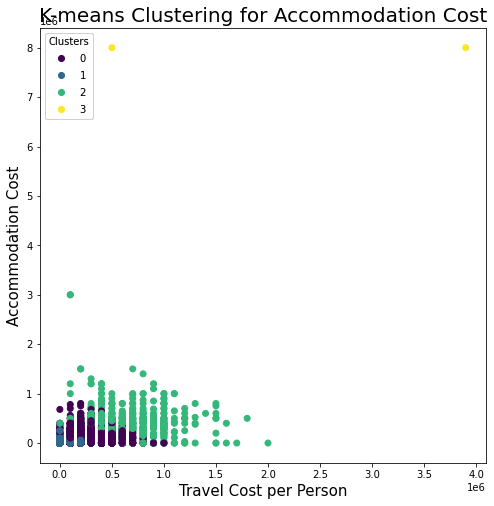

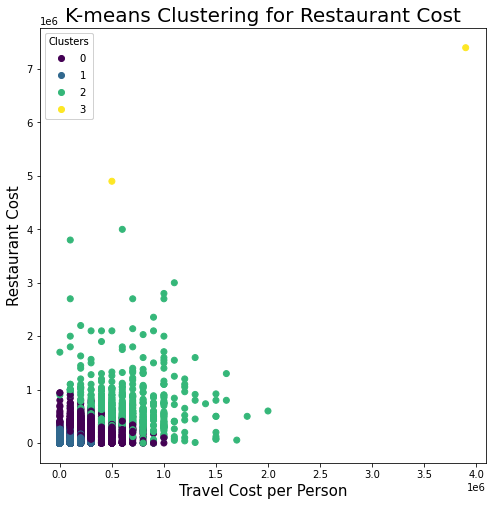

In [21]:
# scatter plot 그리기 for 'A9C'
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(df['D_TRA1_ONE_COST'], df['A9C'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Travel Cost per Person', fontsize=15)
ax.set_ylabel('Accommodation Cost', fontsize=15)
ax.set_title('K-means Clustering for Accommodation Cost', fontsize=20)

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

# scatter plot 그리기 for 'A9D'
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(df['D_TRA1_ONE_COST'], df['A9D'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('Travel Cost per Person', fontsize=15)
ax.set_ylabel('Restaurant Cost', fontsize=15)
ax.set_title('K-means Clustering for Restaurant Cost', fontsize=20)

legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

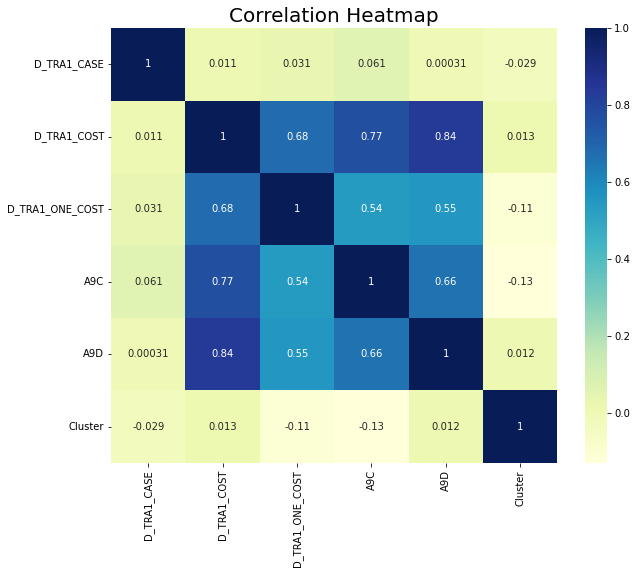

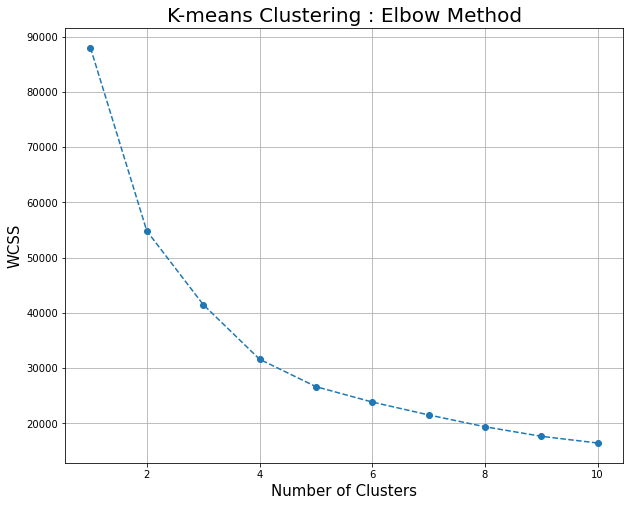

In [22]:
# '여행 유형' 칼럼을 숫자로 변환
df['D_TRA1_CASE'] = encoder.fit_transform(df['D_TRA1_CASE'])

# 상관계수 행렬 계산
corr_matrix = df.corr()

# Heatmap으로 상관계수 행렬을 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap', fontsize=20)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 8))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters', fontsize=15)
plt.ylabel('WCSS', fontsize=15)
plt.title('K-means Clustering : Elbow Method', fontsize=20)
plt.grid(True)
plt.show()